# Functional Encryption - Classification and information leakage

We have seen how to improve the character recognition by replacing the argmax at the output of the private network with additional layers. We are now interested in finding if we can use the output of the private network to improve the font recognition. To do this, we first train the private network on the digit recognition task. We then freeze the private layers and replace the argmax with new layers which form what we call the collateral model and which try to predict the font.

As there are only two fonts, a perfectly blind network should have 50% accuracy in the font recognition task.

# 3 Collateral Learning


We will use the code directly from the repo, to make the notebook more readable.

In [19]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import learn
from learn import main, train, test, show_results, show_confusion_matrix
from learn.models import QuadNet

## 3.1 Loading the quadratic baseline
Let's train the baseline model and this how we can use its output to train a collateral network!

In [21]:
N_CHAR = 10

class Parser:
    def __init__(self):
        self.epochs = 20
        self.lr = 0.0006
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

In [24]:
results = {}
quad_model = QuadNet(N_CHAR)
optimizer = optim.Adam(quad_model.parameters(), lr=self.lr)
args = Parser()
results['QuadNet'], model, pred_labels = main(
    model=quad_model,
    args=args,
    optimizer=optimizer,
    model_type='quad',
    task='char',
    return_model=True,
    return_pred_label=True
)


Training set 60000 items
Testing set  10000 items
Learning on char 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332097
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.189784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.105172
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.077282

Test set: Average loss: 0.0874, Accuracy: 9747/10000 (97.47%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.066652
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.067274
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.055420
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.015269

Test set: Average loss: 0.0636, Accuracy: 9825/10000 (98.25%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.033876
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.098051
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.001078
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.002234

Test set: Average loss: 0.0443, Accuracy: 9878/10000 (98.78%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.008741
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.011260
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.006401
Train Epoc

We save the model so that we won't have to train it again. _Make sure have the correct path and directories._

In [25]:
torch.save(model.state_dict(), '../data/models/quad_char.pt')

## 2.2 Setting up the collaterak task

We will now use the output of the trained baseline model which is freezed as an input of another model called the `collateral_model` which will try to predict on another task, namely the family recognition

There are little change compared to the usual test, train and main functions.

In [26]:
def adversarial_train(args, adversarial_model, model, train_loader, adv_optimizer, epoch):
    adversarial_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = model.transform(data)  # <-- This is new
        adv_optimizer.zero_grad()
        output = adversarial_model(data)
        loss = F.nll_loss(output, target)

        loss.backward()
        adv_optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def adversarial_test(args, adversarial_model, model, test_loader):
    adversarial_model.eval()
    test_loss = 0
    correct = 0
    pred_labels = None
    with torch.no_grad():
        for data, target in test_loader:
            data = model.transform(data) # <-- This is new: like the forward but without the log softmax
            output = adversarial_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            pred_labels_batch = torch.stack((pred, target.view_as(pred))).view(2, args.test_batch_size)
            if pred_labels is None:
                pred_labels = pred_labels_batch
            else:
                pred_labels = torch.cat((pred_labels, pred_labels_batch), dim=1).view(2, -1)

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return acc, pred_labels.transpose(0, 1)


This is the collateral model that we will use. We use the same CNN structure as seen previously.

In [27]:
class CollateralCNN(nn.Module):
    def __init__(self, output_size):
        super(CollateralCNN, self).__init__()
        self.lin1 = nn.Linear(N_CHAR, 784)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = self.lin1(x)
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [28]:
import torch.optim as optim
import torch.utils.data as utils

class Parser:
    def __init__(self):
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.seed = 1
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300
        
def build_tensor_dataset(data, target):
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([i[0] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset
    

The base quadratic model is already trained to detect char, which it does not to badly.
We compute explicitely the weight sum of the quadratic model parameters to verify that this private model is left unchanged after the collateral learning phase.

In [29]:
quad_param_norm = quad_model.proj1.weight.norm() + quad_model.diag1.weight.norm()
quad_param_norm

tensor(8.9486, grad_fn=<AddBackward0>)

We new try to detect using its output, the family of the original input data.

In [30]:
data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data

Training set 60000 items
Testing set  10000 items


In [34]:
def collateral_phase(model):
    args = Parser()

    torch.manual_seed(args.seed)

    # setting = the family recognition task
    train_dataset = build_tensor_dataset(train_data, train_target_family)
    test_dataset = build_tensor_dataset(test_data, test_target_family)
    
    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    
    adversarial_model = CollateralCNN(output_size=N_CHAR)
    adversarial_optimizer = optim.SGD(adversarial_model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs = []
    for epoch in range(1, args.epochs + 1):
        adversarial_train(args, adversarial_model, model, train_loader, adversarial_optimizer, epoch)
        acc, pred_labels = adversarial_test(args, adversarial_model, model, test_loader)
        test_perfs.append(acc)
        
    return test_perfs, pred_labels
        


In [35]:
test_perfs, pred_labels = collateral_phase(quad_model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.379620
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.108436
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.353031
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.093687

Test set: Average loss: 0.2377, Accuracy: 9000/10000 (90.00%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.206386
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.366531
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.403316
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.114806

Test set: Average loss: 0.2051, Accuracy: 9167/10000 (91.67%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.207643
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.211668
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.160555
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.196850

Test set: Average loss: 0.2123, Accuracy: 9114/10000 (91.14%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.323305
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.167466
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.124736
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.114201

Test set: Average loss: 0.1

The learning curve:

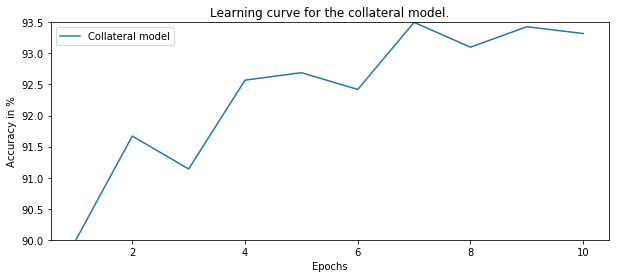

In [41]:
show_results({'Collateral model': test_perfs}, title="Learning curve for the collateral model.")

### Discussion

First, let's verify that the private model weights have not changed

In [37]:
assert quad_param_norm == quad_model.proj1.weight.norm() + quad_model.diag1.weight.norm()

Second, one could ask the difference with the setting where we put a CNN (the same) on top of the private network to learn font family recognition in Part 2. The major difference is that in Part 2 we could modify the private network weights, while here we couldn't, and moreover its weights were optimised to perform a completely different task!

Last, as this experiment shows, the prediction accuracy of the model is embarrassingly good! This shows that the information contained in the 10 neurons output is far more important than just information about characters. In particular, we can infer quite precisely information about the font of the original data.

## Conclusion

This experiment proves the information leakage in the public output on which we publicly apply the argmax, as we are able the distinguish the font with over 93%.

Note however that this is less than the 98.5% we had in Part 2. In addition, recall that what we do here has no impoact on the main task accuracy.

We will now use the technique seen in Part 2 to also add extra layers on the main task. We will see how this affects the collateral accuracy and this will allow to adjust a new hyper-parameter: the size of the private output of the quadratic model. Our intuition is that reducing this parameter means less information is leaked and therefore the collateral learning is harder.


### If you like it, star it!

The easiest way to show support is just by starring the Repos! This helps raise awareness on this topics and is a precious feedback for the repo maintainers!

- [Star the Repo](https://github.com/LaRiffle/collateral-learning)